## Chunking to Network Graph

This notebook walks through an example that builds a co-occurrence matrix for two strings taken from two speeches and turns them into a network graph based on a cosine similarity. 

In [1]:
import nltk
from nltk import RegexpParser
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import spacy
import pandas as pd

In [2]:
string = 'Already, we have done more to advance the cause of health care reform in the last thirty days than we have in the last decade.  When it was days old, this Congress passed a law to provide and protect health insurance for eleven million American children whose parents work full-time.  Our recovery plan will invest in electronic health records and new technology that will reduce errors, bring down costs, ensure privacy, and save lives.  It will launch a new effort to conquer a disease that has touched the life of nearly every American by seeking a cure for cancer in our time.  And it makes the largest investment ever in preventive care, because that is one of the best ways to keep our people healthy and our costs under control.'
string2 = 'A future of hope and opportunity requires that all our citizens have affordable and available health care. When it comes to health care, government has an obligation to care for the elderly, the disabled, and poor children, and we will meet those responsibilities. For all other Americans, private health care insurance is the best way to meet their needs. But many Americans cannot afford a health insurance policy.'
string3 = 'And the vice president is right; we must also work with the private sector to connect every classroom, every clinic, every library, every hospital in America into a national information superhighway by the year 2000. Think of it. Instant access to information will increase productivity. It will help to educate our children. It will provide better medical care. It will create jobs. And I call on the Congress to pass legislation to establish that information superhighway this year.'

Putting the strings into a list for some experiments with TF-IDF

In [3]:
strings = list((string, string2, string3))

Some brief cleaning up using tokens and part of speech tagging

In [4]:
sentences = nltk.sent_tokenize(string)
sentences = [nltk.word_tokenize(sent) for sent in sentences]
sentences = [nltk.pos_tag(sent) for sent in sentences]

In [5]:
sentences

[[('Already', 'RB'),
  (',', ','),
  ('we', 'PRP'),
  ('have', 'VBP'),
  ('done', 'VBN'),
  ('more', 'JJR'),
  ('to', 'TO'),
  ('advance', 'VB'),
  ('the', 'DT'),
  ('cause', 'NN'),
  ('of', 'IN'),
  ('health', 'NN'),
  ('care', 'NN'),
  ('reform', 'NN'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('last', 'JJ'),
  ('thirty', 'NN'),
  ('days', 'NNS'),
  ('than', 'IN'),
  ('we', 'PRP'),
  ('have', 'VBP'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('last', 'JJ'),
  ('decade', 'NN'),
  ('.', '.')],
 [('When', 'WRB'),
  ('it', 'PRP'),
  ('was', 'VBD'),
  ('days', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('this', 'DT'),
  ('Congress', 'NNP'),
  ('passed', 'VBD'),
  ('a', 'DT'),
  ('law', 'NN'),
  ('to', 'TO'),
  ('provide', 'VB'),
  ('and', 'CC'),
  ('protect', 'VB'),
  ('health', 'NN'),
  ('insurance', 'NN'),
  ('for', 'IN'),
  ('eleven', 'JJ'),
  ('million', 'CD'),
  ('American', 'JJ'),
  ('children', 'NNS'),
  ('whose', 'WP$'),
  ('parents', 'NNS'),
  ('work', 'VBP'),
  ('full-time', 'NN'),
  ('.', '.'

We're chunking based on the following Regex parser, which takes an optional determinant, any number of adjectives, and any number of nouns in sequence as a noun phrase

In [6]:
grammar = "NP: {<DT>?<JJ.*><NN.*>+}"

In [7]:
cp = nltk.RegexpParser(grammar)
for i in sentences:
    result = cp.parse(i)
    print(result)

(S
  Already/RB
  ,/,
  we/PRP
  have/VBP
  done/VBN
  more/JJR
  to/TO
  advance/VB
  the/DT
  cause/NN
  of/IN
  health/NN
  care/NN
  reform/NN
  in/IN
  (NP the/DT last/JJ thirty/NN days/NNS)
  than/IN
  we/PRP
  have/VBP
  in/IN
  (NP the/DT last/JJ decade/NN)
  ./.)
(S
  When/WRB
  it/PRP
  was/VBD
  days/NNS
  old/JJ
  ,/,
  this/DT
  Congress/NNP
  passed/VBD
  a/DT
  law/NN
  to/TO
  provide/VB
  and/CC
  protect/VB
  health/NN
  insurance/NN
  for/IN
  eleven/JJ
  million/CD
  (NP American/JJ children/NNS)
  whose/WP$
  parents/NNS
  work/VBP
  full-time/NN
  ./.)
(S
  Our/PRP$
  recovery/NN
  plan/NN
  will/MD
  invest/VB
  in/IN
  (NP electronic/JJ health/NN records/NNS)
  and/CC
  (NP new/JJ technology/NN)
  that/WDT
  will/MD
  reduce/VB
  errors/NNS
  ,/,
  bring/VBG
  down/RP
  costs/NNS
  ,/,
  ensure/VB
  privacy/NN
  ,/,
  and/CC
  save/VB
  lives/NNS
  ./.)
(S
  It/PRP
  will/MD
  launch/VB
  (NP a/DT new/JJ effort/NN)
  to/TO
  conquer/VB
  a/DT
  disease/NN
  that

A separate approach is to use the spacy function for noun chunks which automates the process. I'll use that for the rest of the notebook

In [8]:
def spacy_fxn(strings):
    
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(strings)
    print(doc)
    l = []
    for token in doc.noun_chunks:
        print(token)
        l.append(token)
    print(l)
    
    new_dict = {}
    for i in l:
        if str(i) in new_dict:
            new_dict[str(i)] += 1
        else:
            new_dict[str(i)] = 1
    return new_dict

In [9]:
dict1 = spacy_fxn(string)

Already, we have done more to advance the cause of health care reform in the last thirty days than we have in the last decade.  When it was days old, this Congress passed a law to provide and protect health insurance for eleven million American children whose parents work full-time.  Our recovery plan will invest in electronic health records and new technology that will reduce errors, bring down costs, ensure privacy, and save lives.  It will launch a new effort to conquer a disease that has touched the life of nearly every American by seeking a cure for cancer in our time.  And it makes the largest investment ever in preventive care, because that is one of the best ways to keep our people healthy and our costs under control.
we
the cause
health care reform
the last thirty days
we
the last decade
it
this Congress
a law
health insurance
eleven million American children
whose parents
Our recovery plan
electronic health records
new technology
errors
costs
privacy
lives
It
a new effort
a d

In [10]:
dict1

{'we': 2,
 'the cause': 1,
 'health care reform': 1,
 'the last thirty days': 1,
 'the last decade': 1,
 'it': 2,
 'this Congress': 1,
 'a law': 1,
 'health insurance': 1,
 'eleven million American children': 1,
 'whose parents': 1,
 'Our recovery plan': 1,
 'electronic health records': 1,
 'new technology': 1,
 'errors': 1,
 'costs': 1,
 'privacy': 1,
 'lives': 1,
 'It': 1,
 'a new effort': 1,
 'a disease': 1,
 'the life': 1,
 'nearly every American': 1,
 'a cure': 1,
 'cancer': 1,
 'our time': 1,
 'the largest investment': 1,
 'preventive care': 1,
 'the best ways': 1,
 'our people': 1,
 'our costs': 1,
 'control': 1}

In [11]:
dict2 = spacy_fxn(string2)

A future of hope and opportunity requires that all our citizens have affordable and available health care. When it comes to health care, government has an obligation to care for the elderly, the disabled, and poor children, and we will meet those responsibilities. For all other Americans, private health care insurance is the best way to meet their needs. But many Americans cannot afford a health insurance policy.
A future
hope
opportunity
all our citizens
affordable and available health care
it
health care
government
an obligation
poor children
we
those responsibilities
all other Americans
private health care insurance
the best way
their needs
many Americans
a health insurance policy
[A future, hope, opportunity, all our citizens, affordable and available health care, it, health care, government, an obligation, poor children, we, those responsibilities, all other Americans, private health care insurance, the best way, their needs, many Americans, a health insurance policy]


In [12]:
dict3 = spacy_fxn(string3)

And the vice president is right; we must also work with the private sector to connect every classroom, every clinic, every library, every hospital in America into a national information superhighway by the year 2000. Think of it. Instant access to information will increase productivity. It will help to educate our children. It will provide better medical care. It will create jobs. And I call on the Congress to pass legislation to establish that information superhighway this year.
the vice president
we
the private sector
every classroom
every clinic
every library
every hospital
America
a national information superhighway
the year
it
Instant access
information
productivity
It
our children
It
better medical care
It
jobs
I
the Congress
legislation
that information superhighway
[the vice president, we, the private sector, every classroom, every clinic, every library, every hospital, America, a national information superhighway, the year, it, Instant access, information, productivity, It, ou

In [13]:
dict1_df = pd.DataFrame(dict1, index =[0])

In [14]:
df_asint = dict1_df.astype(int)
coocc = df_asint.T.dot(df_asint)
coocc

,we,the cause,health care reform,the last thirty days,the last decade,it,this Congress,a law,health insurance,eleven million American children,...,nearly every American,a cure,cancer,our time,the largest investment,preventive care,the best ways,our people,our costs,control
we,4,2,2,2,2,4,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
the cause,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
health care reform,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
the last thirty days,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
the last decade,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
it,4,2,2,2,2,4,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
this Congress,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
a law,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
health insurance,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
eleven million American children,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [15]:
dict2_df = pd.DataFrame(dict2, index =[0])

In [16]:
df_asint1 = dict2_df.astype(int)
coocc1 = df_asint1.T.dot(df_asint1)
coocc1

,A future,hope,opportunity,all our citizens,affordable and available health care,it,health care,government,an obligation,poor children,we,those responsibilities,all other Americans,private health care insurance,the best way,their needs,many Americans,a health insurance policy
A future,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
hope,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
opportunity,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
all our citizens,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
affordable and available health care,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
it,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
health care,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
government,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
an obligation,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
poor children,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [17]:
dict3_df = pd.DataFrame(dict3, index =[0])

In [18]:
df_asint3 = dict3_df.astype(int)
coocc2 = df_asint3.T.dot(df_asint3)
coocc2

,the vice president,we,the private sector,every classroom,every clinic,every library,every hospital,America,a national information superhighway,the year,...,information,productivity,It,our children,better medical care,jobs,I,the Congress,legislation,that information superhighway
the vice president,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
we,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
the private sector,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
every classroom,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
every clinic,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
every library,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
every hospital,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
America,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
a national information superhighway,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1
the year,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,1


Here we're adding the two co-occurrence matrices. 

In [19]:
c = coocc1.add(coocc, fill_value = 0)
c = c.fillna(0)
x = c.add(coocc2, fill_value = 0)
x = x.fillna(0)

In [20]:
x.columns

Index(['A future', 'America', 'I', 'Instant access', 'It', 'Our recovery plan',
       'a cure', 'a disease', 'a health insurance policy', 'a law',
       'a national information superhighway', 'a new effort',
       'affordable and available health care', 'all other Americans',
       'all our citizens', 'an obligation', 'better medical care', 'cancer',
       'control', 'costs', 'electronic health records',
       'eleven million American children', 'errors', 'every classroom',
       'every clinic', 'every hospital', 'every library', 'government',
       'health care', 'health care reform', 'health insurance', 'hope',
       'information', 'it', 'jobs', 'legislation', 'lives', 'many Americans',
       'nearly every American', 'new technology', 'opportunity',
       'our children', 'our costs', 'our people', 'our time', 'poor children',
       'preventive care', 'privacy', 'private health care insurance',
       'productivity', 'that information superhighway', 'the Congress',
       

Taking a pairwise cosine similarity which we can use to determine how the rows relate to each other (we might need a different similiarity measure)

In [21]:
sim = pd.DataFrame(cosine_similarity(x), index=x.columns, columns = x.columns)
sim.head()

,A future,America,I,Instant access,It,Our recovery plan,a cure,a disease,a health insurance policy,a law,...,the last thirty days,the life,the private sector,the vice president,the year,their needs,this Congress,those responsibilities,we,whose parents
A future,1.000000,0.086066,0.086066,0.086066,0.125988,0.152944,0.152944,0.152944,1.000000,0.152944,...,0.152944,0.152944,0.086066,0.086066,0.086066,1.000000,0.152944,1.000000,0.419079,0.152944
America,0.086066,1.000000,1.000000,1.000000,0.946623,0.207322,0.207322,0.207322,0.086066,0.207322,...,0.207322,0.207322,1.000000,1.000000,1.000000,0.086066,0.207322,0.086066,0.533300,0.207322
I,0.086066,1.000000,1.000000,1.000000,0.946623,0.207322,0.207322,0.207322,0.086066,0.207322,...,0.207322,0.207322,1.000000,1.000000,1.000000,0.086066,0.207322,0.086066,0.533300,0.207322
Instant access,0.086066,1.000000,1.000000,1.000000,0.946623,0.207322,0.207322,0.207322,0.086066,0.207322,...,0.207322,0.207322,1.000000,1.000000,1.000000,0.086066,0.207322,0.086066,0.533300,0.207322
It,0.125988,0.946623,0.946623,0.946623,1.000000,0.511595,0.511595,0.511595,0.125988,0.511595,...,0.511595,0.511595,0.946623,0.946623,0.946623,0.125988,0.511595,0.125988,0.763700,0.511595


Using the similiarity matrix, we draw the network graph which gives us two distinct 'topics', in this case corresponding to each speech

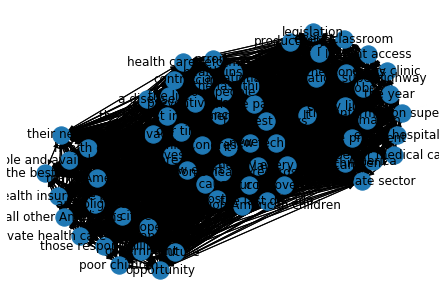

In [22]:
graph = nx.DiGraph(sim)
nx.draw(graph, with_labels=True)
plt.show()

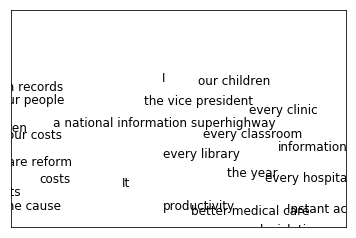

In [23]:
labels = nx.draw_networkx_labels(graph, pos=nx.spring_layout(graph))
plt.show()

In [24]:
for line in nx.generate_multiline_adjlist(graph):
    print(line)

A future 67
A future {'weight': 1.0000000000000002}
America {'weight': 0.08606629658238704}
I {'weight': 0.08606629658238704}
Instant access {'weight': 0.08606629658238704}
It {'weight': 0.12598815766974242}
Our recovery plan {'weight': 0.15294382258037453}
a cure {'weight': 0.15294382258037453}
a disease {'weight': 0.15294382258037453}
a health insurance policy {'weight': 1.0000000000000002}
a law {'weight': 0.15294382258037453}
a national information superhighway {'weight': 0.08606629658238704}
a new effort {'weight': 0.15294382258037453}
affordable and available health care {'weight': 1.0000000000000002}
all other Americans {'weight': 1.0000000000000002}
all our citizens {'weight': 1.0000000000000002}
an obligation {'weight': 1.0000000000000002}
better medical care {'weight': 0.08606629658238704}
cancer {'weight': 0.15294382258037453}
control {'weight': 0.15294382258037453}
costs {'weight': 0.15294382258037453}
electronic health records {'weight': 0.15294382258037453}
eleven million

preventive care {'weight': 0.2073221072156823}
privacy {'weight': 0.2073221072156823}
private health care insurance {'weight': 0.08606629658238704}
productivity {'weight': 0.9999999999999998}
that information superhighway {'weight': 0.9999999999999998}
the Congress {'weight': 0.9999999999999998}
the best way {'weight': 0.08606629658238704}
the best ways {'weight': 0.2073221072156823}
the cause {'weight': 0.2073221072156823}
the largest investment {'weight': 0.2073221072156823}
the last decade {'weight': 0.2073221072156823}
the last thirty days {'weight': 0.2073221072156823}
the life {'weight': 0.2073221072156823}
the private sector {'weight': 0.9999999999999998}
the vice president {'weight': 0.9999999999999998}
the year {'weight': 0.9999999999999998}
their needs {'weight': 0.08606629658238704}
this Congress {'weight': 0.2073221072156823}
those responsibilities {'weight': 0.08606629658238704}
we {'weight': 0.5332997301241935}
whose parents {'weight': 0.2073221072156823}
every library 67

that information superhighway {'weight': 0.2073221072156823}
the Congress {'weight': 0.2073221072156823}
the best way {'weight': 0.15294382258037453}
the best ways {'weight': 0.9999999999999997}
the cause {'weight': 0.9999999999999997}
the largest investment {'weight': 0.9999999999999997}
the last decade {'weight': 0.9999999999999997}
the last thirty days {'weight': 0.9999999999999997}
the life {'weight': 0.9999999999999997}
the private sector {'weight': 0.2073221072156823}
the vice president {'weight': 0.2073221072156823}
the year {'weight': 0.2073221072156823}
their needs {'weight': 0.15294382258037453}
this Congress {'weight': 0.9999999999999997}
those responsibilities {'weight': 0.15294382258037453}
we {'weight': 0.8961931372304827}
whose parents {'weight': 0.9999999999999997}
private health care insurance 67
private health care insurance {'weight': 1.0000000000000002}
A future {'weight': 1.0000000000000002}
America {'weight': 0.08606629658238704}
I {'weight': 0.08606629658238704}


One last thing here, playing around with TF-IDF, which is a sklearn function that takes in a list of the strings (in this case strings). The question becomes how does this relate to the earlier attempts to count frequencies of noun phrases and how they co-occur with each other based on paragraphs

In [25]:
vectorizer = TfidfVectorizer()
response = vectorizer.fit_transform(strings)

In [26]:
vectorizer.get_feature_names()

['2000',
 'access',
 'advance',
 'afford',
 'affordable',
 'all',
 'already',
 'also',
 'america',
 'american',
 'americans',
 'an',
 'and',
 'available',
 'because',
 'best',
 'better',
 'bring',
 'but',
 'by',
 'call',
 'cancer',
 'cannot',
 'care',
 'cause',
 'children',
 'citizens',
 'classroom',
 'clinic',
 'comes',
 'congress',
 'connect',
 'conquer',
 'control',
 'costs',
 'create',
 'cure',
 'days',
 'decade',
 'disabled',
 'disease',
 'done',
 'down',
 'educate',
 'effort',
 'elderly',
 'electronic',
 'eleven',
 'ensure',
 'errors',
 'establish',
 'ever',
 'every',
 'for',
 'full',
 'future',
 'government',
 'has',
 'have',
 'health',
 'healthy',
 'help',
 'hope',
 'hospital',
 'in',
 'increase',
 'information',
 'instant',
 'insurance',
 'into',
 'invest',
 'investment',
 'is',
 'it',
 'jobs',
 'keep',
 'largest',
 'last',
 'launch',
 'law',
 'legislation',
 'library',
 'life',
 'lives',
 'makes',
 'many',
 'medical',
 'meet',
 'million',
 'more',
 'must',
 'national',
 'near

In [27]:
z = pd.DataFrame(response.toarray())
z.head()

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,0.000000,0.000000,0.079414,0.000000,0.000000,0.000000,0.079414,0.000000,0.000000,0.158828,...,0.079414,0.000000,0.079414,0.093807,0.060397,0.079414,0.140710,0.000000,0.060397,0.000000
1,0.000000,0.000000,0.000000,0.116243,0.116243,0.232487,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.116243,0.000000,0.068655,0.088406,0.000000,0.068655,0.000000,0.000000,0.000000
2,0.104482,0.104482,0.000000,0.000000,0.000000,0.000000,0.000000,0.104482,0.104482,0.000000,...,0.000000,0.000000,0.000000,0.061709,0.000000,0.000000,0.246835,0.104482,0.079461,0.208964
